# Train RNN to perform context-dependent decision-making task

In [1]:
# import related packages
import numpy as np
import torch
from torch import nn, optim
from data import gen_data
from model import SingleAreaRNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## setup task parameters and create RNN

In [ ]:
# network parameters
input_size = 5
hidden_size = 256   # 256 for single area RNN, and you may try 128 for each area in 2aRNN.
output_size = 2
model = SingleAreaRNN(input_size, hidden_size, output_size)
model = model.to(device)
# task parameters
task_timing = [300, 1000, 900, 500] # fixation, stimulus, delay, response

In [3]:
n_epochs = 100
n_trials_per_epoch = 100
batch_size = 20
num_batches = n_trials_per_epoch // batch_size

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
loss_list = []
for epoch in range(n_epochs):
    # randomize the length of delay period for each epoch
    task_timing_ = task_timing.copy()
    task_timing_[2] = np.random.randint(300, 1500)
    x, y, metadata = gen_data(n_trials_per_epoch, timing=task_timing_)
    x = torch.from_numpy(x).to(device)
    y = torch.from_numpy(y).to(device)
    loss_buff = 0
    for batch in range(num_batches):
        output = model(x[batch*batch_size:(batch+1)*batch_size])
        loss = criterion(output, y[batch*batch_size:(batch+1)*batch_size])
        loss_buff += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss_buff/num_batches)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss {loss_list[-1]}')

Epoch 0, Loss 0.23186560869216918
Epoch 10, Loss 0.04320256635546684
Epoch 20, Loss 0.030849913135170937
Epoch 30, Loss 0.018892632424831392
Epoch 40, Loss 0.02523856982588768
Epoch 50, Loss 0.01408611461520195
Epoch 60, Loss 0.012492276169359684
Epoch 70, Loss 0.011268785409629344
Epoch 80, Loss 0.010234569385647773
Epoch 90, Loss 0.011445471830666066


## plot training loss

Text(0, 0.5, 'Loss')

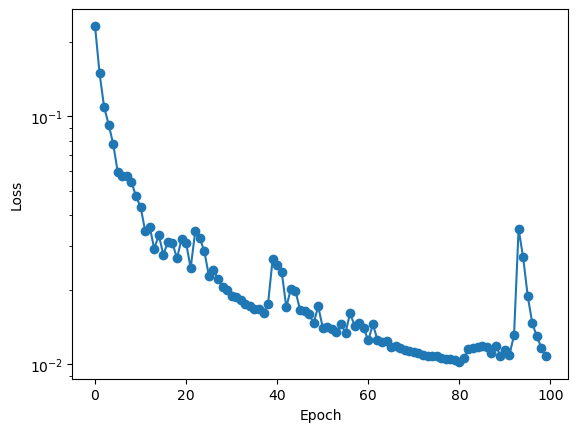

In [4]:
import matplotlib.pyplot as plt
plt.semilogy(loss_list, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Test network performances

In [5]:
with torch.no_grad():
    x, y, metadata = gen_data(100, timing=task_timing)
    outputs, hs = model(torch.from_numpy(x), return_hidden=True)
    outputs = outputs.detach().cpu().numpy()
    hs = hs.detach().cpu().numpy()
    decisions = np.sign(outputs[:,-1,1])

In [6]:
# compute the accuracy of RNN decision
accuracy = np.mean(decisions == metadata['action'])
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


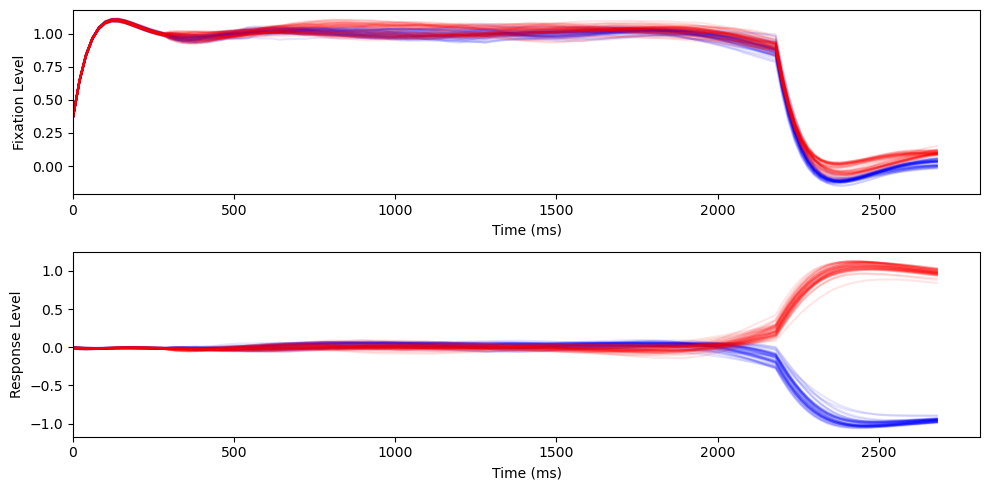

In [7]:
fig, ax = plt.subplots(2,1, figsize=(10, 5))
t = np.arange(outputs.shape[1]) * 20    # 20 ms per time step
ax[0].plot(t, outputs[metadata['action']==-1, :, 0].T, 'b', alpha=0.1)
ax[0].plot(t, outputs[metadata['action']==1, :, 0].T, 'r', alpha=0.1)
ax[1].plot(t, outputs[metadata['action']==-1, :, 1].T, 'b', alpha=0.1)
ax[1].plot(t, outputs[metadata['action']==1, :, 1].T, 'r', alpha=0.1)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Fixation Level')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Response Level')
ax[0].set_xlim(0)
ax[1].set_xlim(0)
plt.tight_layout()

## Basic state space analysis

Text(0, 0.5, 'Explained Variance ratio')

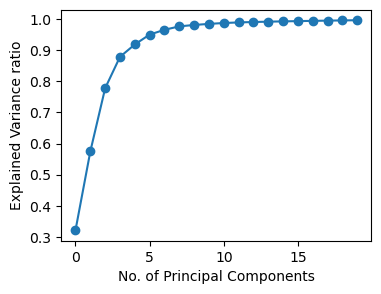

In [8]:
from sklearn.decomposition import PCA
n_pc = 20
pca = PCA(n_components=n_pc)
hs_pca = pca.fit_transform(hs.reshape(-1, hidden_size)).reshape(hs.shape[0], hs.shape[1], n_pc)
plt.figure(figsize=(4,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('No. of Principal Components')
plt.ylabel('Explained Variance ratio')

## Visualize state space trajectories

Text(0, 0.5, 'PC2')

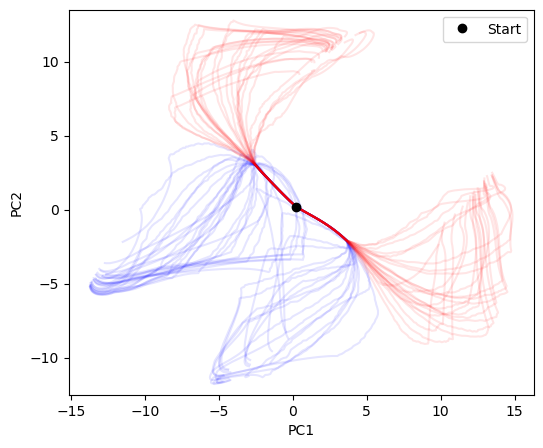

In [9]:
plt.figure(figsize=(6,5))
plt.plot(
    hs_pca[metadata['action']==-1, :, 0].T,
    hs_pca[metadata['action']==-1, :, 1].T,
    'b', alpha=0.1);
plt.plot(
    hs_pca[metadata['action']==1, :, 0].T,
    hs_pca[metadata['action']==1, :, 1].T,
    'r', alpha=0.1);
plt.plot(hs_pca[0, 0, 0], hs_pca[0, 0, 1], 'ko', label='Start')
plt.gca().axis('equal')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')